This notebook demonstrates parser code for the X4 and TI radar. It also shows code from the X4 threshold module.


In [16]:
import numpy as np
import csv
import pandas as pd

This code below demonstrates the X4 parser for putting real and imaginary parts together:

In [23]:
def iq_data(filename,csvname):
    with open(filename, "rb") as f:
        data = np.fromfile(f, dtype=np.float32)
    for i in range(0, len(data) // 363 - 1):
        temp = data[3 * (i + 1) + 360 * i:3 * (i + 1) + 360 * (i + 1)]
        iqdata = []
        for j in range(0, 180):
            if temp[j + 180] > 0:
                iqdata.append(str(round(temp[j], 4)) + "+" + str(round(temp[j + 180], 4)) + "j")
            else:
                iqdata.append(str(round(temp[j], 4)) + str(round(temp[j + 180], 4)) + "j")
        with open(csvname+'.csv', 'a', newline="") as csvFile:
             writer = csv.writer(csvFile)
             writer.writerow(iqdata)
    f.close()
    csvFile.close()
    return 'converted'
iq_data("X4data.dat","X4iq")


'converted'

This code below demonstrates the X4 parser for raw data:


In [24]:
def raw_data(filename,csvname):
    with open(filename, "rb") as f:
        data = np.fromfile(f, dtype=np.float32)
    for i in range(0, len(data) // 1473 - 1):
        temp = data[3 + 1470 * i:3 + 1470 * (i + 1)]

        with open(csvname+'.csv', 'a', newline="") as csvFile:
            writer = csv.writer(csvFile)
            writer.writerow(temp)
    f.close()
    csvFile.close()
    return 'converted'

raw_data("X4data.dat", "X4raw")


'converted'

This code is used to read data taken in by TI radar and parses it to a csv file.


In [37]:
def readTSWdata(filename,csvname):
    # Global Variables - change based on sensor config
    numADCSamples = 256 # number of ADC samples per chirp
    numADCBits = 16 # number of ADC bits per sample
    numRX = 4 # number of receivers
    numLanes = 2 # do not change. number of lanes is always 2
    isReal = 0 # set to 1 if real only data, 0 if complex data

    # Read file
    with open(filename, 'rb') as f:
        adcData = np.fromfile(f, dtype="int16")
        for i in range(0, len(adcData)):
            if adcData[i] > 0:
                adcData[i] = adcData[i] - 2**15
            else:
                adcData[i] = adcData[i] + 2**15
        #adcData = adcData - 2**15
        # if 12 or 14 bits ADC per sample compensate for sign extension
        if numADCBits != 16:
            l_max = 2**(numADCBits-1)-1
            for index, val in enumerate(adcData):
                if adcData[index] > l_max:
                    adcData[index] -= 2**(numADCBits)
    f.close()
    fileSize = len(adcData)
    # Organize data by LVDS lane
    # Reshape data based on two samples per LVDS lane
    adcData = np.reshape(adcData, (numLanes*2, -1))
    
    # For real data
    if isReal == 1:
        # seperate each LVDS lane into rows
        LVDS = np.zeros((2, len(adcData[0,:])*2), dtype="uint16")
        # interleave the two sample sets from each lane
        for i in range(2, len(LVDS)-1, 2):
            LVDS[0,0:i] = adcData[0,:]
        for i in range(3,len(LVDS), 2):
            LVDS[0,1:i] = adcData[1,:]

        if numRX > 1:
            for i in range(2, len(LVDS)-1, 2):
                LVDS[1,0:i] = adcData[2,:]
            for i in range(3,len(LVDS), 2):
                LVDS[1,1:i] = adcData[3,:]
            LVDS = np.reshape(LVDS[0:1,:], (1, -1))
            
    # For complex data
    else:
        fileSize = fileSize/2
        # seperate each LVDS lane into rows
        LVDS = np.zeros((2,len(adcData[1,:])), dtype="complex")
        # combine real and imaginary parts
        LVDS[0,:] = [complex(a,b) for a,b in zip(adcData[0,:], adcData[1,:])]
        if numRX > 1:
            LVDS[1,:] = [complex(a,b) for a,b in zip(adcData[2,:], adcData[3,:])]
            LVDS = np.reshape(LVDS, (1, -1))
            
    # organize data by receiver
    # seperate each receiver into a single row
    adcData = np.zeros((numRX, int(fileSize/numRX)), dtype="complex")
    if numRX > 1:
        for j in range(0,numRX):
            iterator = 0
            for i in range(j*numADCSamples, int(fileSize), numADCSamples*numRX):
                adcData[j,iterator:iterator+numADCSamples] = LVDS[0, i:i+numADCSamples]
                iterator = iterator + numADCSamples
    else:
        adcData = LVDS[1,:]
        
    data = pd.DataFrame(adcData)
    data.to_csv(csvname+'.csv', index=False, header=False, mode='w')

    return 'converted'

readTSWdata('TIdata.bin', "TIdata")

'converted'

This code below is converts your csv file into a list to be used by other threshold functions.


In [4]:
def csv_into_list(filename): 
    with open(filename,"rt") as csvfile:
        
        data = list(csv.reader(csvfile))  #Declarations 
        mean=[0]*len(data[0])
        
        for i in range (len(data)):  #Goes through the 180 by n CSV file 
            
            for j in range (len(data[i])):
                
                data[i][j]=complex(data[i][j]) #Converts string to complex number
                mean[j]+=complex(data[i][j]) #Adds up numbers for each 180 column to get to get a mean for each column 
        
        for i in range (len(data)):
            
            for j in range (len(data[i])):
                
                            data[i][j]=abs(data[i][j]-mean[j]/len(data)) #Each complex number is subtracted by it's respective column mean to even it out and the magnitude is taken since it is complex 
                                
    data=np.array(data[0:])    
    csvfile.close()
    
    return data

csv_into_list("Heli150040.csv")


array([[2.12019056e-04, 2.66481591e-04, 3.51781533e-04, ...,
        2.51499279e-04, 2.63311858e-04, 2.49837321e-04],
       [1.36839763e-03, 1.13654408e-03, 7.92290507e-04, ...,
        3.49299137e-04, 1.30311682e-04, 1.87399805e-04],
       [7.57068081e-04, 6.54611670e-04, 6.83445863e-04, ...,
        6.95117789e-05, 2.17249015e-04, 3.85946482e-04],
       ...,
       [9.57032957e-04, 5.99047943e-04, 5.37280418e-04, ...,
        2.95999810e-04, 2.42217122e-04, 3.25605109e-04],
       [2.37110777e-03, 1.98986895e-03, 1.28061167e-03, ...,
        2.95363991e-04, 1.50057104e-04, 2.33757752e-04],
       [6.45687293e-04, 5.61334516e-04, 1.63285784e-04, ...,
        6.64671904e-05, 2.17249015e-04, 1.93614790e-04]])

This code find the range bin the target is in


In [5]:
def range_finder(filename,estimated_threshold):   
    data=csv_into_list(filename)
    positive_finds=[]
    
    for i in range (len(data[5])):     #Finds points for the 5th sample
        
        if (estimated_threshold<data[5][i]):
            positive_finds.append(i+1)
    
    return positive_finds

range_finder("Heli150040.csv",0.02)


[9]

This code determines the noise to power estimate. 


In [6]:
def noise_power_estimate(filename,estimated_threshold): 
    data=csv_into_list(filename)
    positive_finds=range_finder(filename,estimated_threshold)
     
    sum_data=sum(data[5])
    
    for i in range (len(positive_finds)):          #Subtracts the positive/guard cells from the overall sum 
        sum_data-=data[5][positive_finds[i]]
        sum_data-=data[5][positive_finds[i]-1]
        sum_data-=data[5][positive_finds[i]+1]
    
    noise_power=sum_data/(len(data[5])-len(positive_finds)*3)  #Takes average excluding guard and positive numbers
    
    return noise_power

noise_power_estimate("Heli150040.csv",0.02)


0.00045988029076158947

This code translate the range bin value into an actual range in centimeters. 


In [7]:
def distance_finder(filename,estimate_threshold):
    positive_finds=range_finder(filename,estimate_threshold)
    distance=[]
    
    for i in range (len(positive_finds)):
        
        distance.append(positive_finds[i]*5.25-18)
    
    return distance

distance_finder("Heli150040.csv",0.02)


[29.25]

This code plots the csv function as a graph of range bin against signal strength.


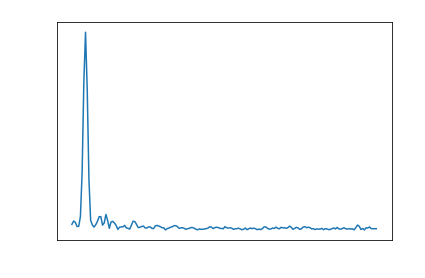

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_data(filename):
    COLOR = 'white'
    data=csv_into_list(filename)
    plt.plot(data[5])
    plt.xlabel('Range bin')
    plt.ylabel('Signal strength')
    plt.title('Detection of target in range bins with equivalent signal strength')
    plt.rcParams['text.color'] = COLOR
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    plt.show()

plot_data("Heli150040.csv")    

A function to read the OS1-16 lidar's internal timestamp


In [4]:
def get_timestamp(data, arg, single_row=False, multiple_row=False, row_section=False):
    
    data = pd.read_csv(data)
    timestamp = []

    print("NOTE: All timestamps measured in seconds and each element is a timestamp for single azimuth block")
    if single_row is True:
        for col in range(1, len(data.columns)-1, 788):
            timestamp_segment = list(data.values[arg, col:col+8])
            timestamp_segment.reverse()
            timestamp_segment = [int(elem) for index, elem in enumerate(timestamp_segment)]
            del timestamp_segment[0:3]
            timestamp_segment[0] = float(timestamp_segment[0])
            time = float("".join(map(str, timestamp_segment)))
            timestamp.append(time)
    elif multiple_row is True:
        for index, elem in enumerate(arg):
            timestamp.append("new row")
            for col in range(1, len(data.columns)-1, 788):
                timestamp_segment = list(data.values[elem, col:col+8])
                timestamp_segment.reverse()
                timestamp_segment = [int(elem) for index, elem in enumerate(timestamp_segment)]
                del timestamp_segment[0:3]
                timestamp_segment[0] = float(timestamp_segment[0])
                time = float("".join(map(str, timestamp_segment)))
                timestamp.append(time)
    elif row_section is True:
        for row in range(arg[0], arg[1]+1):
            timestamp.append("new row")
            for col in range(1, len(data.columns)-1, 788):
                timestamp_segment = list(data.values[row, col:col+8])
                timestamp_segment.reverse()
                timestamp_segment = [int(elem) for index, elem in enumerate(timestamp_segment)]
                del timestamp_segment[0:3]
                timestamp_segment[0] = float(timestamp_segment[0])
                time = float("".join(map(str, timestamp_segment)))
                timestamp.append(time)

    return timestamp

print(get_timestamp('lidar_data3.csv', 0, single_row=True))

NOTE: All timestamps measured in seconds and each element is a timestamp for single azimuth block
[33.0202114185206, 33.0202116496, 33.0202117174244, 33.0202119463, 33.0202120189236, 33.020212246132, 33.0202123185122, 33.02021254748, 33.0202126186208, 33.020212861196, 33.020212917536, 33.02021314678, 33.020213218632, 33.02021345714, 33.020213518654, 33.020213754204]


A function to read the lidar's packets frame ID


In [5]:
def get_frame_id(data, arg, single_row=False, multiple_row=False, row_section=False):
    data = pd.read_csv(data)
    frame_id = []

    print("NOTE: Each element is a frame ID for single azimuth block")
    if single_row is True:
        for col in range(9, len(data.columns) - 1, 788):
            frame_id_segment = list(data.values[arg, col:col + 2])
            frame_id_segment.reverse()
            frame_id_segment = [int(elem) for index, elem in enumerate(frame_id_segment)]
            frame = int("".join(map(str, frame_id_segment)))
            frame_id.append(frame)
    elif multiple_row is True:
        for index, elem in enumerate(arg):
            frame_id.append("new row")
            for col in range(9, len(data.columns) - 1, 788):
                frame_id_segment = list(data.values[elem, col:col + 2])
                frame_id_segment.reverse()
                frame_id_segment = [int(elem) for index, elem in enumerate(frame_id_segment)]
                frame = int("".join(map(str, frame_id_segment)))
                frame_id.append(frame)
    elif row_section is True:
        for row in range(arg[0], arg[1] + 1):
            frame_id.append("new row")
            for col in range(9, len(data.columns) - 1, 788):
                frame_id_segment = list(data.values[row, col:col + 2])
                frame_id_segment.reverse()
                frame_id_segment = [int(elem) for index, elem in enumerate(frame_id_segment)]
                frame = int("".join(map(str, frame_id_segment)))
                frame_id.append(frame)

    return frame_id

print(get_frame_id("lidar_data3.csv", 0, single_row=True))


NOTE: Each element is a frame ID for single azimuth block
[222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237]


A function to read the lidar packet's measurement ID


In [6]:
def get_measurement_id(data, arg, single_row=False, multiple_row=False, row_section=False):
    data = pd.read_csv(data)
    measurement_id = []

    print("NOTE: Each element is a measurement ID for single azimuth block")
    if single_row is True:
        for col in range(11, len(data.columns)-1,788):
            measurement_id_segment = list(data.values[arg, col:col+2])
            measurement_id_segment.reverse()
            measurement_id_segment = [int(elem) for index, elem in enumerate(measurement_id_segment)]
            measurement = int("".join(map(str, measurement_id_segment)))
            measurement_id.append(measurement)
    elif multiple_row is True:
        for index, elem in enumerate(arg):
            measurement_id.append("new row")
            for col in range(11, len(data.columns)-1,788):
                measurement_id_segment = list(data.values[elem, col:col+2])
                measurement_id_segment.reverse()
                measurement_id_segment = [int(elem) for index, elem in enumerate(measurement_id_segment)]
                measurement = int("".join(map(str, measurement_id_segment)))
                measurement_id.append(measurement)
    elif row_section is True:
        for row in range(arg[0], arg[1]+1):
            measurement_id.append("new row")
            for col in range(11, len(data.columns)-1, 788):
                measurement_id_segment = list(data.values[row, col:col+2])
                measurement_id_segment.reverse()
                measurement_id_segment = [int(elem) for index, elem in enumerate(measurement_id_segment)]
                measurement = int("".join(map(str, measurement_id_segment)))
                measurement_id.append(measurement)

    return measurement_id

print(get_measurement_id("lidar_data3.csv", 0, single_row=True))


NOTE: Each element is a measurement ID for single azimuth block
[4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239, 4239]


A function to get a lidar packet's encoder count


In [7]:
def get_encoder_count(data, arg, single_row=False, multiple_row=False, row_section=False):
    data = pd.read_csv(data)

    encoder_count = []

    print("NOTE: Each element is a encoder count for single azimuth block")
    if single_row is True:
        for col in range(13, len(data.columns) - 1, 788):
            encoder_count_segment = list(data.values[arg, col:col + 4])
            encoder_count_segment.reverse()
            encoder_count_segment = [int(elem) for index, elem in enumerate(encoder_count_segment)]
            encoder = int("".join(map(str, encoder_count_segment)))
            encoder_count.append(encoder)

    elif multiple_row is True:
        for index, elem in enumerate(arg):
            encoder_count.append('new row')
            for col in range(13, len(data.columns) - 1, 788):
                encoder_count_segment = list(data.values[elem, col:col + 4])
                encoder_count_segment.reverse()
                encoder_count_segment = [int(elem) for index, elem in enumerate(encoder_count_segment)]
                encoder = int("".join(map(str, encoder_count_segment)))
                encoder_count.append(encoder)
    elif row_section is True:
        for row in range(arg[0], arg[1] + 1):
            encoder_count.append('new row')
            for col in range(13, len(data.columns) - 1, 788):
                encoder_count_segment = list(data.values[row, col:col + 4])
                encoder_count_segment.reverse()
                encoder_count_segment = [int(elem) for index, elem in enumerate(encoder_count_segment)]
                encoder = int("".join(map(str, encoder_count_segment)))
                encoder_count.append(encoder)

    return encoder_count

print(get_encoder_count("lidar_data3.csv", 0, single_row=True))


NOTE: Each element is a encoder count for single azimuth block
[7680, 76168, 770, 7788, 77176, 788, 7896, 78184, 7916, 79104, 79192, 8024, 80112, 80200, 8132, 81120]


A function to read lidar packets range values in millimeter


In [9]:
def get_range(data, arg, single_row=False, multiple_row=False, row_section=False, azimuth_block=0):
    data = pd.read_csv(data)
    range_mm = []

    print("NOTE: Each element is a range in millimeters for single channel in azimuth block")
    if single_row is True:
        for col in (range(16+azimuth_block, azimuth_block+784, 12)):
            range_segment = list(data.values[arg, col:col+3])
            range_segment = [int(elem) for index, elem in enumerate(range_segment)]
            rang = int("".join(map(str, range_segment)))
            range_mm.append(rang)
    elif multiple_row is True:
        for index, elem in enumerate(arg):
            range_mm.append('new row')
            for col in (range(16+azimuth_block, azimuth_block+784, 12)):
                range_segment = list(data.values[elem, col:col+3])
                range_segment = [int(elem) for index, elem in enumerate(range_segment)]
                rang = int("".join(map(str, range_segment)))
                range_mm.append(rang)
    elif row_section is True:
        for row in range(arg[0], arg[1]+1):
            range_mm.append('new row')
            for col in (range(16+azimuth_block, azimuth_block+784, 12)):
                range_segment = list(data.values[row, col:col+3])
                range_segment = [int(elem) for index, elem in enumerate(range_segment)]
                rang = int("".join(map(str, range_segment)))
                range_mm.append(rang)

    return range_mm

print(get_range("lidar_data3.csv", 0, single_row=True))


NOTE: Each element is a range in millimeters for single channel in azimuth block
[12810, 0, 0, 0, 19810, 0, 0, 0, 3810, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1874, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


A function to get lidar packet's signal photons


In [11]:
def get_signal_photons(data, arg, single_row=False, multiple_row=False, row_section=False, azimuth_block=0):
    data = pd.read_csv(data)
    signal_photons = []

    print("NOTE: Each element is a signal photon count for single channel in azimuth block")
    if single_row is True:
        for col in (range(22+azimuth_block, azimuth_block+784, 12)):
            signal_photons_segment = list(data.values[arg, col:col+2])
            signal_photons_segment = [int(elem) for index, elem in enumerate(signal_photons_segment)]
            signl_p = int("".join(map(str, signal_photons_segment)))
            signal_photons.append(signl_p)
    elif multiple_row is True:
        for index, elem in enumerate(arg):
            signal_photons.append('new row')
            for col in (range(22+azimuth_block, azimuth_block+784, 12)):
                signal_photons_segment = list(data.values[elem, col:col+2])
                signal_photons_segment = [int(elem) for index, elem in enumerate(signal_photons_segment)]
                signl_p = int("".join(map(str, signal_photons_segment)))
                signal_photons.append(signl_p)
    elif row_section is True:
        for row in range(arg[0], arg[1]+1):
            signal_photons.append('new row')
            for col in (range(22+azimuth_block, azimuth_block+784, 12)):
                signal_photons_segment = list(data.values[row, col:col+2])
                signal_photons_segment = [int(elem) for index, elem in enumerate(signal_photons_segment)]
                signl_p = int("".join(map(str, signal_photons_segment)))
                signal_photons.append(signl_p)

    return signal_photons

print(get_signal_photons("lidar_data3.csv", 0, single_row=True))


NOTE: Each element is a signal photon count for single channel in azimuth block
[26, 0, 0, 0, 48, 0, 0, 0, 26, 0, 0, 0, 14, 0, 0, 0, 11, 0, 0, 0, 15, 0, 0, 0, 17, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


A function to read lidar packet reflectivity values


In [12]:
def get_reflectivity(data, arg, single_row=False, multiple_row=False, row_section=False, azimuth_block=0):
    data = pd.read_csv(data)
    reflectivity = []

    print("NOTE: Each element is a reflectivity for single channel in azimuth block")
    if single_row is True:
        for col in (range(20+azimuth_block, azimuth_block+784, 12)):
            reflectivity_segment = list(data.values[arg, col:col+2])
            reflectivity_segment = [int(elem) for index, elem in enumerate(reflectivity_segment)]
            reflect = int("".join(map(str, reflectivity_segment)))
            reflectivity.append(reflect)
    elif multiple_row is True:
        for index, elem in enumerate(arg):
            reflectivity.append('new row')
            for col in (range(20+azimuth_block, azimuth_block+784, 12)):
                reflectivity_segment = list(data.values[elem, col:col+2])
                reflectivity_segment = [int(elem) for index, elem in enumerate(reflectivity_segment)]
                reflect = int("".join(map(str, reflectivity_segment)))
                reflectivity.append(reflect)
    elif row_section is True:
        for row in range(arg[0], arg[1]+1):
            reflectivity.append('new row')
            for col in (range(20+azimuth_block, azimuth_block+784, 12)):
                reflectivity_segment = list(data.values[row, col:col+2])
                reflectivity_segment = [int(elem) for index, elem in enumerate(reflectivity_segment)]
                reflect = int("".join(map(str, reflectivity_segment)))
                reflectivity.append(reflect)

    return reflectivity

print(get_reflectivity("lidar_data3.csv", 0, single_row=True))


NOTE: Each element is a reflectivity for single channel in azimuth block
[19, 0, 0, 0, 36, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


A function to read lidar packet noise photons values


In [13]:
def get_noise_photons(data, arg, single_row=False, multiple_row=False, row_section=False, azimuth_block=0):
    data = pd.read_csv(data)
    noise_photons = []

    print("NOTE: Each element is a noise photon count for single channel in azimuth block")
    if single_row is True:
        for col in (range(24+azimuth_block, azimuth_block+788, 12)):
            noise_photons_segment = list(data.values[arg, col:col+3])
            noise_photons_segment = [int(elem) for index, elem in enumerate(noise_photons_segment)]
            noise_p = int("".join(map(str, noise_photons_segment)))
            noise_photons.append(noise_p)
    elif multiple_row is True:
        for index, elem in enumerate(arg):
            noise_photons.append('new row')
            for col in (range(24+azimuth_block, azimuth_block+788, 12)):
                noise_photons_segment = list(data.values[elem, col:col+3])
                noise_photons_segment = [int(elem) for index, elem in enumerate(noise_photons_segment)]
                noise_p = int("".join(map(str, noise_photons_segment)))
                noise_photons.append(noise_p)
    elif row_section is True:
        for row in range(arg[0], arg[1]+1):
            noise_photons.append('new row')
            for col in (range(24+azimuth_block, azimuth_block+788, 12)):
                noise_photons_segment = list(data.values[row, col:col+3])
                noise_photons_segment = [int(elem) for index, elem in enumerate(noise_photons_segment)]
                noise_p = int("".join(map(str, noise_photons_segment)))
                noise_photons.append(noise_p)


    return noise_photons

print(get_noise_photons("lidar_data3.csv", 0, single_row=True))



NOTE: Each element is a noise photon count for single channel in azimuth block
[1456, 3633, 1, 129128, 1704, 400, 1920, 124176, 2274, 360, 177190, 61, 2043, 10, 369, 1287, 1214, 21022, 80, 132112, 2344, 170254, 226136, 216255, 2543, 8, 252248, 248, 1962, 9239, 150, 9663, 1647, 128148, 70, 232178, 1536, 172, 12864, 202, 1895, 2870, 157112, 214, 2203, 24172, 12639, 19253, 5012, 136128, 4, 94238, 193, 1280, 4160, 208124, 1474, 255143, 4064, 90, 2433, 848, 16724, 20068]
